In [82]:
### First imports and default parameters

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Overwritting matplotlib default linestyle of negative contours
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

SEED = 42

# 1. First steps with unsupervised anomaly detection algorithms

The goal of this section is to get familiar with different unsupervised anomaly detection approaches and algorithms. In order to visualise the output of the different algorithms we consider a toy data set consisting in a two-dimensional Gaussian mixture.

### Generating the data set

In [345]:
from utils import GaussianMixture

n_samples = 500
n_features = 2
weight_1 = 0.5
weight_2 = 0.5
mean_1 = np.zeros(n_features)
mean_2 = -1 * np.ones(n_features)
cov_1 = np.array([[2., 2.,], [2., 4.]])
cov_2 = 2 * np.identity(n_features)
weights = np.array([weight_1, weight_2])
means = np.array([mean_1, mean_2])
covars = np.array([cov_1, cov_2])

gm = GaussianMixture(weights, means, covars, random_state=SEED)
X = gm.sample(n_samples)

### Plot the samples and levels set of the density

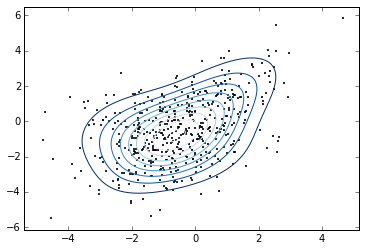

In [346]:
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0)
X_range[:, 1] = np.max(X, axis=0)

h = 0.1  # step size of the mesh
x_min, x_max = X_range[0, 0] - 0.1, X_range[0, 1] + 0.1
y_min, y_max = X_range[1, 0] - 0.1, X_range[1, 1] + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = gm.density(grid)
Z = Z.reshape(xx.shape)

plt.figure()
plt.contour(xx, yy, Z, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.show()

The goal is to estimate a Minimum volume set with mass at least 0.95:

In [347]:
alpha_set = 0.95

from scipy.stats.mstats import mquantiles

n_quantile = 1000000
Xq = gm.sample(n_quantile)
density_q = gm.density(Xq)
tau = mquantiles(density_q, 1 - alpha_set)

X_outliers = X[gm.density(X) < tau]

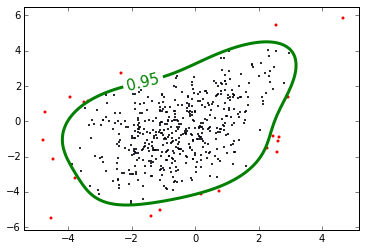

In [92]:
plt.figure()
c_0 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau[0]: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red', s=4.)
plt.show()

### 1.1. Density estimation

We are going to use the plug-in approach to estimate the Minimum Volume set with mass at least 0.95, which is also a density level set under regularity assumptions on the distribution.

In [93]:
from sklearn.neighbors.kde import KernelDensity

# Estimate density with a Gaussian kernel density estimator
kde = KernelDensity(kernel='gaussian')
kde = kde.fit(X)

In [94]:
kde_X = kde.score_samples(X)

In [95]:
tau_kde = mquantiles(kde_X, 1 - alpha_set)

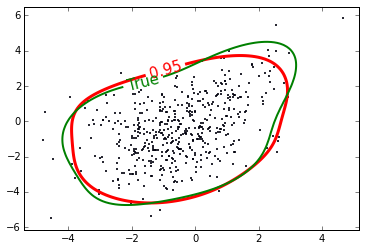

In [96]:
Z_kde = kde.score_samples(grid)
Z_kde = Z_kde.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_kde, levels=tau_kde, colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_kde[0]: str(alpha_set)})
c_1 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=2, label='True')
plt.clabel(c_1, inline=1, fontsize=15, fmt={tau[0]: 'True'})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.legend()
plt.show()

#### Bandwidth selection with cross validation

In [97]:
from sklearn.model_selection import GridSearchCV

In [98]:
grid_cv = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': np.linspace(0.1, 2.0, 30)}, cv=3)
grid_cv.fit(X)
grid_cv.best_params_

{'bandwidth': 0.7551724137931034}

In [99]:
kde_best = grid_cv.best_estimator_

kde_best_X = kde_best.score_samples(X)
tau_kde_best = mquantiles(kde_best_X, 1 - alpha_set)

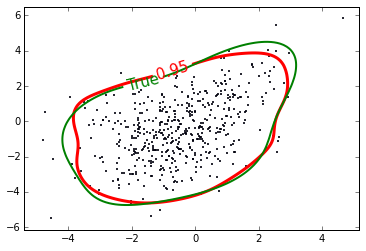

In [100]:
Z_kde_best = kde_best.score_samples(grid)
Z_kde_best = Z_kde_best.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_kde_best, levels=tau_kde_best, colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_kde_best[0]: str(alpha_set)})
c_1 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=2, label='True')
plt.clabel(c_1, inline=1, fontsize=15, fmt={tau[0]: 'True'})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.legend()
plt.show()

### 1.2. One-Class SVM

In [108]:
from sklearn.svm import OneClassSVM

In [361]:
nu = 0.05
# ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu)
ocsvm = OneClassSVM(kernel='rbf', gamma=50., nu=nu)
# ocsvm = OneClassSVM(kernel='rbf', nu=nu)
ocsvm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=50.0, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [362]:
X_outliers = X[ocsvm.predict(X) == -1]

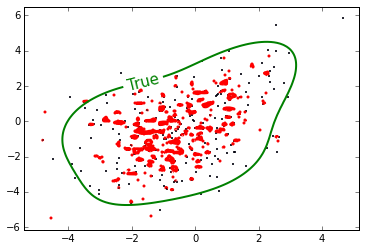

In [363]:
Z_ocsvm = ocsvm.decision_function(grid)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_ocsvm, levels=[0], colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={0: str(alpha_set)})
c_1 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=2, label='True')
plt.clabel(c_1, inline=1, fontsize=15, fmt={tau[0]: 'True'})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=4., color='red')
plt.legend()
plt.show()

We clearly observe that the One-Class SVM has overfitted. We need to change the bandwidth of the rbf kernel. What is the default bandwidth used when we trained the One-Class SVM?

In [364]:
ocsvm?

Answer: gamma = 1/n_features = 0.5. Let's try with a smaller gamma: gamme = 0.05 for instance.

Model selection for the One-Class SVM and unsupervised anomaly detection in general is an ongoing topic of research.

#### Support vectors - Outliers

We should always have: #Outliers/n_samples <= nu <= #SV/n_samples

In [365]:
X_SV = X[ocsvm.support_]
n_SV = len(X_SV)
n_outliers = len(X_outliers)

print('{0:.2f} <= {1:.2f} <= {2:.2f}?'.format(1./n_samples*n_outliers, nu, 1./n_samples*n_SV))

0.42 <= 0.05 <= 0.91?


#### Level sets of the decision function

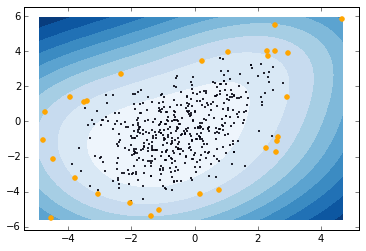

In [285]:
plt.figure()
plt.contourf(xx, yy, Z_ocsvm, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_SV[:, 0], X_SV[:, 1], s=20., color='orange')
plt.show()

OCSVM is like a Kernel Density estimation with a Gaussian kernel but only the set of Support vectors (almost equal to the set of Outliers) are involved in the solution function.

#### With $\nu > 0.05$

In [306]:
nu = 0.4
ocsvm = OneClassSVM(kernel='rbf', gamma=0.5, nu=nu)
ocsvm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.5, kernel='rbf',
      max_iter=-1, nu=0.4, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

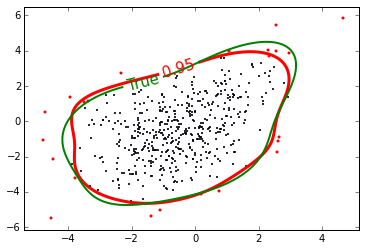

In [307]:
Z_ocsvm = ocsvm.decision_function(grid)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)

ocsvm_X = ocsvm.decision_function(X)
tau_ocsvm = mquantiles(ocsvm_X, 1 - alpha_set)


plt.figure()
c_0 = plt.contour(xx, yy, Z_ocsvm, levels=tau_ocsvm, colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_ocsvm[0]: str(alpha_set)})
c_1 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=2, label='True')
plt.clabel(c_1, inline=1, fontsize=15, fmt={tau[0]: 'True'})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=4., color='red')
plt.legend()
plt.show()

### 1.3. Isolation Forest

In [21]:
from sklearn.ensemble import IsolationForest

In [273]:
# iforest = IsolationForest(n_estimators=1, contamination=0.05)
iforest = IsolationForest(n_estimators=100, contamination=0.05)
iforest = iforest.fit(X)

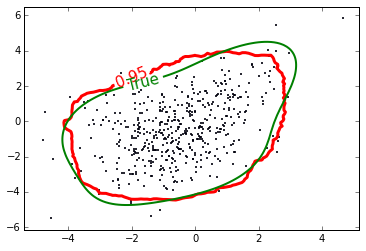

In [274]:
Z_iforest = iforest.decision_function(grid)
Z_iforest = Z_iforest.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_iforest, levels=[iforest.threshold_], colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={iforest.threshold_: str(alpha_set)})
c_1 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=2, label='True')
plt.clabel(c_1, inline=1, fontsize=15, fmt={tau[0]: 'True'})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.legend()
plt.show()

### 1.4. Local Outlier Factor

k-NN based anomaly detection algorithm. Available on the dev version of Scikit-Learn.

### 1.4. Unsupervised as supervised using SVM

#### Generate uniform data in the range of X

In [275]:
### Generating artificial second class 
rng = np.random.RandomState(SEED)

U = np.zeros((n_samples, n_features))
for i in range(n_features):
    U [:, i] = rng.uniform(X_range[i, 0], X_range[i, 1], n_samples)
    
vol = np.prod(X_range[:, 1] - X_range[:, 0])

In [276]:
X_bin = np.r_[X, U]
y_bin = np.r_[np.ones(n_samples), np.zeros(n_samples)].astype(int)

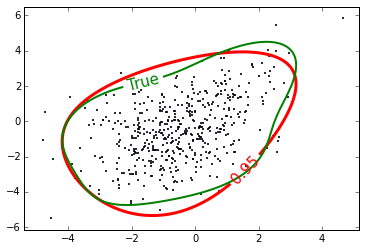

In [277]:
from sklearn.svm import SVC
# SVM parameters

C = 1.
lambda_reg = 0.0001
gamma = 0.01

weight_1 = 1. / ((1. + tau[0]) * lambda_reg * n_samples)
weight_0 = vol * tau[0] / ((1. + tau[0]) * lambda_reg * n_samples)
class_weight = {1: weight_1, 0: weight_0}

clf = SVC(C=C, kernel='rbf', gamma=gamma, class_weight=class_weight)
clf = clf.fit(X_bin, y_bin)

Z_svm = clf.decision_function(grid)
Z_svm = Z_svm.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_svm, levels=[0], colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={0: str(alpha_set)})
c_1 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=2, label='True')
plt.clabel(c_1, inline=1, fontsize=15, fmt={tau[0]: 'True'})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.legend()
plt.show()

# 2. Performance evaluation with Mass Volume curve

In [352]:
from sklearn.model_selection import ShuffleSplit

X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0)
X_range[:, 1] = np.max(X, axis=0)

n_sim = 100000
U = np.zeros((n_sim, n_features))
for i in range(n_features):
    U [:, i] = rng.uniform(X_range[i, 0], X_range[i, 1], n_sim)

### Training on half the data
ss = ShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)

ss = ss.split(X)
train, test = ss.next()

X_train = X[train]
X_test = X[test]
X_train_all = np.r_[U, X_train]
y_train_all = np.r_[np.zeros(n_sim), np.ones(len(train))]
X_test_all = np.r_[U, X_test]
y_test_all = np.r_[np.zeros(n_sim), np.ones(len(test))]

In [355]:
X_train_all.shape

(100250, 2)

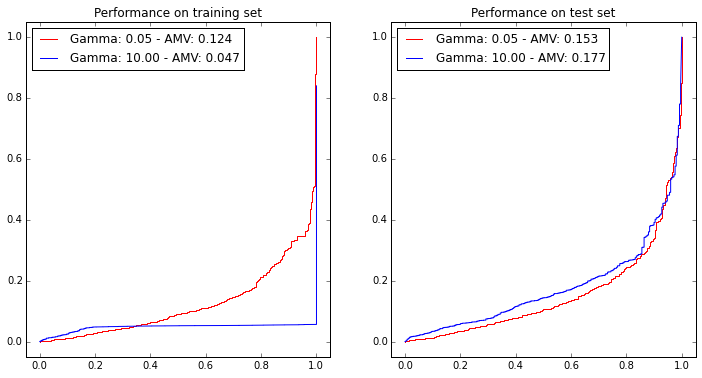

In [372]:
colors = ['red', 'blue']

plt.figure(figsize=(12, 6))

for g, gamma in enumerate([0.05, 10]):
    ocsvm = OneClassSVM(gamma=gamma, nu=0.05)
    ### Train algorithm (fit), compute decision function on train and test, compute ROC and AUC, draw ROC
    ocsvm.fit(X_train)
    ocsvm_train_all = ocsvm.decision_function(X_train_all)
    ocsvm_test_all = ocsvm.decision_function(X_test_all)
    fpr_train_, tpr_train_, _ = roc_curve(y_train_all, -ocsvm_train_all, pos_label=0)
    ocsvm_auc_train = auc(1 - fpr_train_, 1 - tpr_train_)
    fpr_test_, tpr_test_, _ = roc_curve(y_test_all, -ocsvm_test_all, pos_label=0)
    ocsvm_auc_test = auc(1 - fpr_test_, 1 - tpr_test_)
    
    plt.subplot(1, 2, 1)
    plt.title('Performance on training set')
    plt.plot(1 - fpr_train_, 1 - tpr_train_, color=colors[g], label= 'Gamma: {0:.2f} - AMV: {1:.3f}'.format(gamma, ocsvm_auc_train))
    
    plt.subplot(1, 2, 2)
    plt.title('Performance on test set')
    plt.plot(1 - fpr_test_, 1 - tpr_test_, color=colors[g], label= 'Gamma: {0:.2f} - AMV: {1:.3f}'.format(gamma, ocsvm_auc_test))

plt.subplot(1, 2, 1)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.subplot(1, 2, 2)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.show()

# 3. Performance evaluation on real data sets

### 3.1. Shuttle data set

In [28]:
from sklearn.datasets import fetch_mldata

dataset = fetch_mldata('shuttle')
X = dataset.data
y = dataset.target

### Usual setup when using this data set for anomaly detection
# Instances with label 4 are removed
# Normal data: label 1
ind = (y != 4)
X = X[ind, :]
y = y[ind]
y = (y == 1).astype(int)

In [328]:
n_samples, n_features = X.shape
n_samples, n_features

(58725, 3)

In [36]:
'Percentage of anomalies: {0}'.format(1 - np.mean(y))

'Percentage of anomalies: 0.0376160068114'

In [326]:
### Use StratifiedShuffleSplit to preserve the proportion of each class in the train and test sets.
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)

train, test = sss.split(X, y).next()
X_train, y_train = X[train], y[train]
X_test, y_test = X[test], y[test]

In [38]:
print('Percentage of anomalies in train : {0}'.format(1 - np.mean(y_train)))
print('Percentage of anomalies in test : {0}'.format(1 - np.mean(y_test)))

Percentage of anomalies in train : 0.0375996185546
Percentage of anomalies in test : 0.0376323945101


#### Performance on training set and test set - ROC curve - AUC

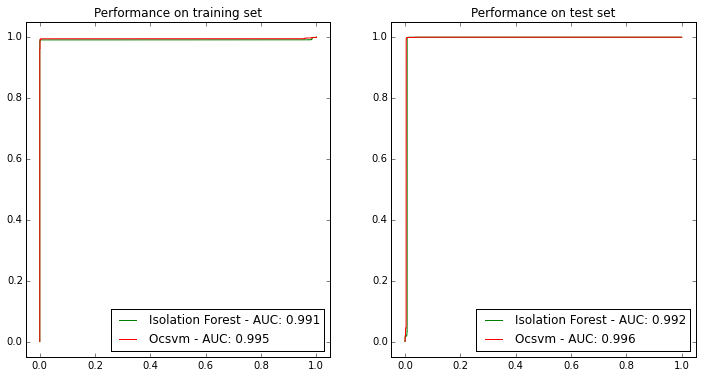

In [70]:
### !!!! This can take a few minutes. You might consider running it with Isolation Forest only at first

from sklearn.metrics import roc_curve, auc

algorithms = [OneClassSVM(), IsolationForest()]
name = ['Isolation Forest', 'Ocsvm']
colors = ['green', 'red']
# algorithms = [IsolationForest()]
# name = ['Isolation Forest']
# colors = ['green']

plt.figure(figsize=(12, 6))

for a, algo in enumerate(algorithms):
    ### Train algorithm (fit), compute decision function on train and test, compute ROC and AUC, draw ROC
    algo.fit(X_train)
    algo_train = algo.decision_function(X_train)
    algo_test = algo.decision_function(X_test)
    fpr_train_, tpr_train_, _ = roc_curve(y_train, -algo_train, pos_label=0)
    algo_auc_train = auc(fpr_train_, tpr_train_)
    fpr_test_, tpr_test_, _ = roc_curve(y_test, -algo_test, pos_label=0)
    algo_auc_test = auc(fpr_test_, tpr_test_)
    
    plt.subplot(1, 2, 1)
    plt.title('Performance on training set')
    plt.plot(fpr_train_, tpr_train_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_train))
    
    plt.subplot(1, 2, 2)
    plt.title('Performance on test set')
    plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test))

plt.subplot(1, 2, 1)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.subplot(1, 2, 2)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.show()

#### Performance - MV curve - AMV

In [331]:
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0)
X_range[:, 1] = np.max(X, axis=0)

n_sim = 100000
U = np.zeros((n_sim, n_features))
for i in range(n_features):
    U [:, i] = rng.uniform(X_range[i, 0], X_range[i, 1], n_sim)

### We add uniform data to compute volumes
X_train_all = np.r_[U, X_train]
X_test_all = np.r_[U, X_test]

# Assigning same label to all data (normal and anomalies): the anomalies are the uniform samples
y_train_all = np.r_[np.zeros(n_sim), np.ones(len(X_train))]
y_test_all = np.r_[np.zeros(n_sim), np.ones(len(X_test))]

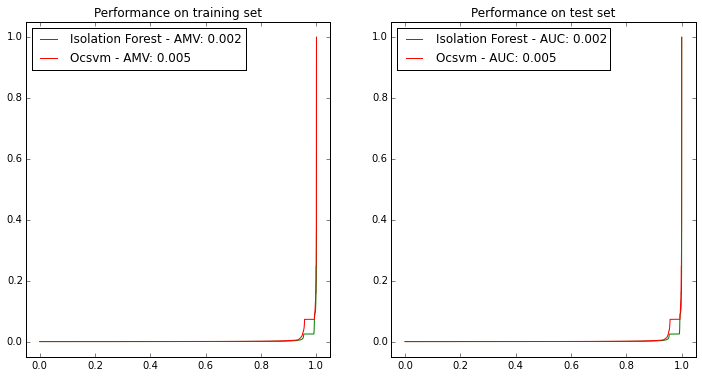

In [332]:
algorithms = [OneClassSVM(), IsolationForest()]
name = ['Isolation Forest', 'Ocsvm']
colors = ['green', 'red']
# algorithms = [IsolationForest()]
# name = ['Isolation Forest']
# colors = ['green']

plt.figure(figsize=(12, 6))

for a, algo in enumerate(algorithms):
    ### Train algorithm (fit), compute decision function on train and test, compute ROC and AUC, draw ROC
    algo.fit(X_train)
    algo_train_all = algo.decision_function(X_train_all)
    algo_test_all = algo.decision_function(X_test_all)
    fpr_train_, tpr_train_, _ = roc_curve(y_train_all, -algo_train_all, pos_label=0)
    algo_auc_train = auc(1 - fpr_train_, 1 - tpr_train_)
    fpr_test_, tpr_test_, _ = roc_curve(y_test_all, -algo_test_all, pos_label=0)
    algo_auc_test = auc(1 - fpr_test_, 1 - tpr_test_)
    
    plt.subplot(1, 2, 1)
    plt.title('Performance on training set')
    plt.plot(1 - fpr_train_, 1 - tpr_train_, color=colors[a], label= '{0} - AMV: {1:.3f}'.format(name[a], algo_auc_train))
    
    plt.subplot(1, 2, 2)
    plt.title('Performance on test set')
    plt.plot(1 - fpr_test_, 1 - tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test))

plt.subplot(1, 2, 1)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.subplot(1, 2, 2)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.show()

### 3.2. Http data set - Network intrusion detection

In [34]:
from sklearn.datasets import fetch_kddcup99

dataset = fetch_kddcup99(subset='http', shuffle=True,
                         percent10=True, random_state=SEED)
X = dataset['data']
X = X.astype('float')
y = dataset['target']
y = (y == 'normal.').astype(int)

### 3.3. Novelty detection

We only train the model on normal data. Here let's train the model on half the normal data.

In [317]:
X_normal = X[y == 1]
X_ano = X[y != 1]
y_normal = y[y == 1]
y_ano = y[y != 1]

In [318]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)

ss = ss.split(X_normal, y_normal)
train_normal, test_normal = ss.next()

In [319]:
X_train = X_normal[train_normal]
X_test = np.r_[X_normal[test_normal], X_ano]
y_test = np.r_[y_normal[test_normal], y_ano]

#### ROC - AUC on test set

In [ ]:
### !!!! This can take a few minutes. You might consider running it with Isolation Forest only at first

algorithms = [OneClassSVM(), IsolationForest()]
name = ['Isolation Forest', 'Ocsvm']
colors = ['green', 'red']
# algorithms = [IsolationForest()]
# name = ['Isolation Forest']
# colors = ['green']

plt.figure(figsize=(12, 6))

for a, algo in enumerate(algorithms):
    ### Train algorithm (fit), compute decision function on train and test, compute ROC and AUC, draw ROC
    algo.fit(X_train)
    algo_test = algo.decision_function(X_test)
    fpr_test_, tpr_test_, _ = roc_curve(y_test, -algo_test, pos_label=0)
    algo_auc_test = auc(fpr_test_, tpr_test_)
    
    plt.subplot(1, 2, 2)
    plt.title('Performance on test set')
    plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test))

plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.legend(loc=0)

plt.show()

#### MV curve on test set

In [334]:
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0)
X_range[:, 1] = np.max(X, axis=0)

n_sim = 100000
U = np.zeros((n_sim, n_features))
for i in range(n_features):
    U [:, i] = rng.uniform(X_range[i, 0], X_range[i, 1], n_sim)

### We add uniform data to compute volumes
X_test_all = np.r_[U, X_test]

# Assigning same label to all data (normal and anomalies): the anomalies are the uniform samples
y_test_all = np.r_[np.zeros(n_sim), np.ones(len(X_test))]

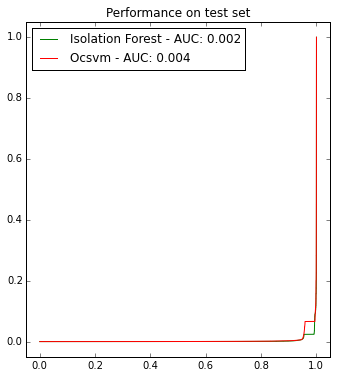

In [335]:
algorithms = [OneClassSVM(), IsolationForest()]
name = ['Isolation Forest', 'Ocsvm']
colors = ['green', 'red']
# algorithms = [IsolationForest()]
# name = ['Isolation Forest']
# colors = ['green']

plt.figure(figsize=(12, 6))

for a, algo in enumerate(algorithms):
    ### Train algorithm (fit), compute decision function on train and test, compute ROC and AUC, draw ROC
    algo.fit(X_train)
    algo_test_all = algo.decision_function(X_test_all)
    fpr_test_all_, tpr_test_all_, _ = roc_curve(y_test_all, -algo_test_all, pos_label=0)
    algo_auc_test = auc(1 - fpr_test_all_, 1 - tpr_test_all_)
    
    plt.subplot(1, 2, 2)
    plt.title('Performance on test set')
    plt.plot(1 - fpr_test_all_, 1 - tpr_test_all_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test))

plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.legend(loc=0)

plt.show()